# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [9]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

plt.rcParams['pcolor.shading'] = 'auto'

register_cmaps()
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [3]:
def dist_vs_idx_dist(com_arr):
    sep_mat = np.linalg.norm(com_arr[:, np.newaxis, :] - com_arr[np.newaxis, :, :], axis=2)
    avg_dist_arr = np.zeros((sep_mat.shape[0]))
    avg_dist_sem_arr = np.zeros((sep_mat.shape[0]))
    for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr[i] = diag.mean()
        avg_dist_sem_arr[i] = stats.sem(diag)
    return avg_dist_arr, avg_dist_sem_arr
    

def sd_num(h5_data):
    ydict = yaml.safe_load(h5_data.attrs['RunConfig'])
    return ydict['rngSeed']

# Distance vs index

number of estimated clusters : 8
number of thresholded clusters : 2
Volume of condensate: 4138151.1045014383 nm$^3$
Volume per bead: 16421.234541672373 nm$^3$
Volume of condensate: 2711793.6878958805 nm$^3$
Volume per bead: 15407.918681226594 nm$^3$


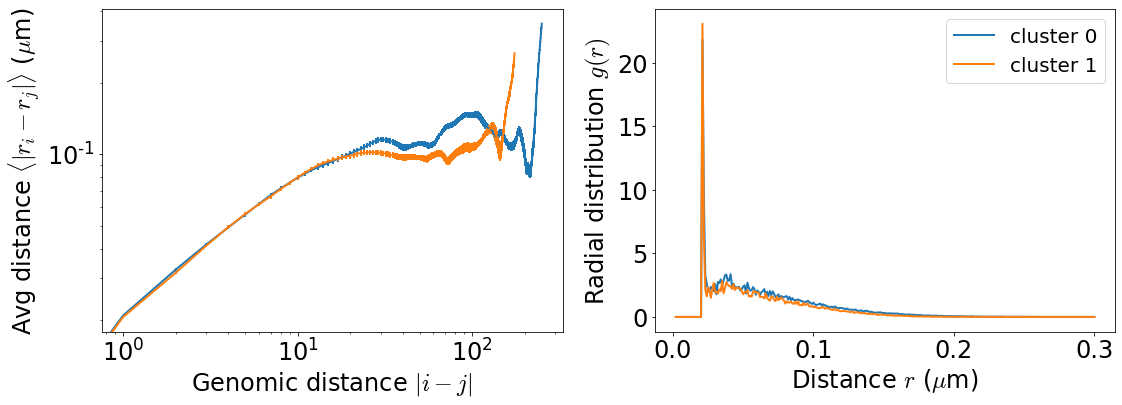

In [10]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
t = -1 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

warnings.filterwarnings('ignore')
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr)

    for i, cli in enumerate(cluster_label_inds):
        clust_ind_com = com_arr[cli]
        hull = ConvexHull(clust_ind_com)
        print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

        avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
        dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                               clust_ind_com[np.newaxis, :, :]),
                              axis=2)
        # hist_max =1.1 * np.max(dist_mat)
        hist_max = .3
        rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, nbins=int(hist_max/.001), hist_max=hist_max)
    
        _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
        _ = axarr[1].plot(rad_bin_edges[2:], rad_distr_func[1:]*hull.volume, label=f'cluster {i}')


_ = axarr[0].set_yscale("log")
_ = axarr[0].set_xscale("log")


_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

_ = axarr[1].legend()
fig.tight_layout()



number of estimated clusters : 8
number of thresholded clusters : 4
Volume of condensate: 3023254.923903121 nm$^3$
Volume per bead: 13742.067835923279 nm$^3$
Volume of condensate: 227265.46519933955 nm$^3$
Volume per bead: 7575.515506644651 nm$^3$
Volume of condensate: 116325.73569777215 nm$^3$
Volume per bead: 5539.320747512959 nm$^3$
Volume of condensate: 2145888.738625435 nm$^3$
Volume per bead: 12622.874933090796 nm$^3$


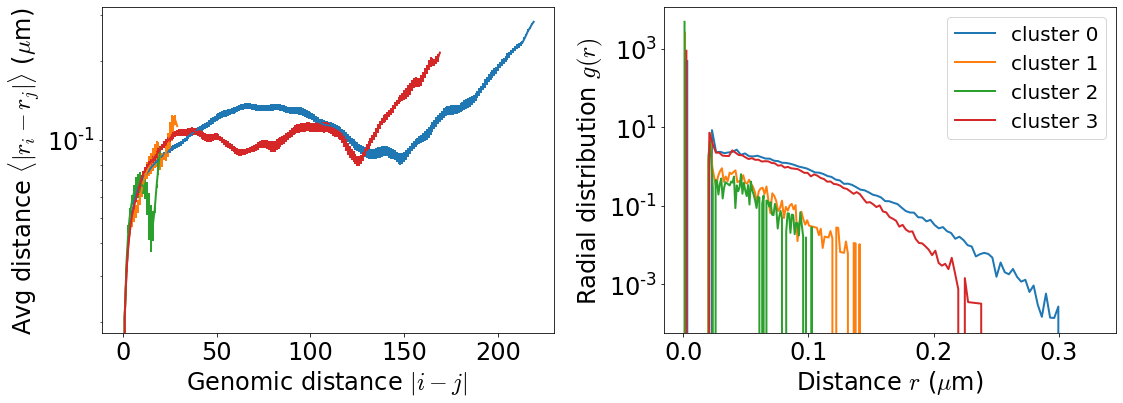

In [12]:
data_path = (
    ceph_path / "22_aLchr700_sticky_runs/22-01-02_aLchr1_scan.12_line700_2xsticky_3umconf_eq/simulations/s6")
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
t = -1000 # Snapshot time to use

fig, axarr = plt.subplots(1,2, figsize=(16, 6))

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, t] + sy_dat[:, 5:8, t])

    clust, cluster_centers, cluster_label_inds = cla.identify_spatial_clusters(
        com_arr)

    for i, cli in enumerate(cluster_label_inds):
        clust_ind_com = com_arr[cli]
        hull = ConvexHull(clust_ind_com)
        print(f"Volume of condensate: {1e9*hull.volume} nm$^3$")
        print(f"Volume per bead: {1e9*hull.volume/float(clust_ind_com.shape[0])} nm$^3$")

        avg_dist_arr, avg_dist_sem_arr = dist_vs_idx_dist(clust_ind_com) 
        dist_mat = np.linalg.norm((clust_ind_com[:, np.newaxis, :] -
                               clust_ind_com[np.newaxis, :, :]),
                              axis=2)
        rad_distr_func, rad_bin_edges = ca.rad_distr_func_at_t(dist_mat, hist_max=1.1*np.max(dist_mat))
    
        _ = axarr[0].errorbar(np.arange(len(avg_dist_arr)), avg_dist_arr, yerr=avg_dist_sem_arr, label=f'cluster {i}')
        _ = axarr[1].plot(rad_bin_edges[1:], rad_distr_func[:]*hull.volume, label=f'cluster {i}')


_ = axarr[0].set_yscale("log")
_ = axarr[1].set_yscale("log")

_ = axarr[0].set_xlabel(r"Genomic distance $|i - j|$ ")
_ = axarr[0].set_ylabel(r"Avg distance $\langle |r_i - r_j|\rangle$ ($\mu$m)")
_ = axarr[1].set_xlabel(r"Distance $r$ ($\mu$m)")
_ = axarr[1].set_ylabel(r"Radial distribution $g(r)$")

_ = axarr[1].legend()
fig.tight_layout()

  0%|          | 0/6 [00:00<?, ?it/s]

0.0


KeyboardInterrupt: 

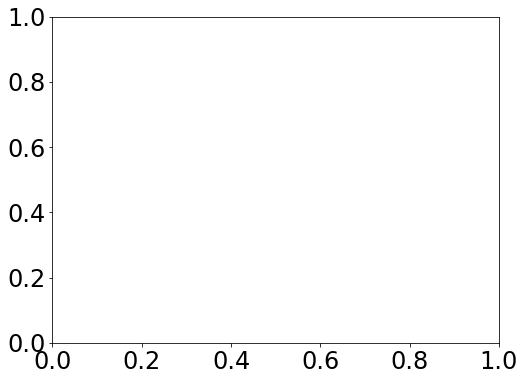

In [14]:
data_path = (ceph_path / '22-07-06_aLc1_line262144_hilbert_confRad3um_256')
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

fig, ax = plt.subplots(figsize=(8,6))
data_list = [] 
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    for time_ind in tqdm(np.arange(0, time_arr.size, time_arr.size/6)):
        print(time_ind)
        sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead, :, time_ind]
        com_arr = .5 * (sy_dat[:, 2:5] + sy_dat[:, 5:8])
        avg_dist_arr = np.zeros(com_arr.shape[0]-1) 
        avg_dist_sem_arr = np.zeros(com_arr.shape[0]-1)
        for i in range(1, com_arr.shape[0]):
            dist_arr = np.linalg.norm(com_arr[i:] - com_arr[:-i], axis=-1)
            avg_dist_arr[i-1] = dist_arr.mean()
            avg_dist_sem_arr[i-1] = stats.sem(dist_arr)
            
        _ = ax.errorbar(np.arange(avg_dist_arr.size)+1, avg_dist_arr, yerr=avg_dist_sem_arr, label=f'time = {time_ind}')
        data_list += [{'avg_dist': avg_dist_arr,
                       'avg_dist_sem_arr': avg_dist_sem_arr,
                       'time': time_ind,
        }]
        

_ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Single cluster characterization

No sylinder data in 8.


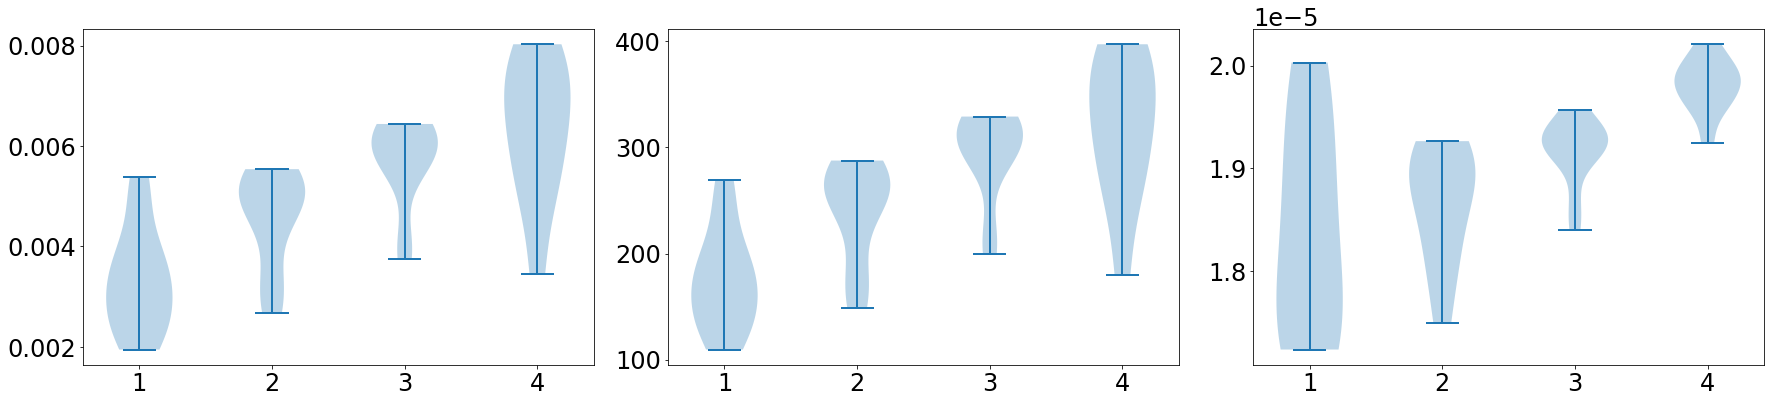

In [15]:
data_path = (ceph_path / "22_aLc800_sticky_runs/22-04-15_aLchr1_scan7.12_line800_stickyL.01-.07_eps1_Ke30_5umconf/simulations")
param_list = [0.04, 0.05, 0.06, 0.07]
# param_list = ["0.04", "0.05", "0.06", "0.07"]
param_paths = [data_path / f"Ls{p}" for p in param_list]
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None

volume_seed_avg_arr = []
num_bead_seed_avg_arr = []
bead_vol_seed_avg_arr = []
for ppaths in param_paths:
    volume_mean_arr = []
    num_bead_mean_arr = []
    bead_vol_mean_arr = []
    for h5_file in ppaths.glob('*/analysis/*.h5'):
        with h5py.File(h5_file, 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]
            analysis_grp = h5_data['analysis']
            
            try:
                sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            except:
                print(f"No sylinder data in {sd_num(h5_data)}.")
                continue
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            largest_cond = 0
            for ci, cond_str in enumerate(h5_data['analysis/condensates']):
                cond_data = h5_data[f'analysis/condensates/{cond_str}']
                max_cond_size = np.max(cond_data[:,2] -cond_data[:, 1])
                if max_cond_size < largest_cond:
                    continue
                largest_cond = max_cond_size
                cond_time = cond_data[:,0]
                # print(cond_data)
                volume_arr = np.zeros(cond_data.shape[0])
                bead_arr = np.zeros(cond_data.shape[0])
                for i, cdat in enumerate(cond_data):
                    t = np.where(time_arr == cdat[0])[0][0]
                    parts = com_arr[int(cdat[1]):int(cdat[2]+1), :, t] 
                    if parts.shape[0] < 4:
                        continue
                    hull = ConvexHull(parts)
                    volume_arr[i] = hull.volume
                    bead_arr[i] = parts.shape[0]
            volume_mean_arr += [volume_arr.mean()]
            num_bead_mean_arr += [bead_arr.mean()]
            bead_vol_mean_arr += [(volume_arr/bead_arr).mean()]
                
    volume_seed_avg_arr += [volume_mean_arr]
    num_bead_seed_avg_arr += [num_bead_mean_arr]
    bead_vol_seed_avg_arr += [bead_vol_mean_arr]
               
fig, axarr = plt.subplots(1,3, figsize=(25, 6))
#print(volume_seed_avg_arr)
#print(np.ma.masked_invalid(np.array(bead_vol_seed_avg_arr)))
_ = axarr[0].violinplot(volume_seed_avg_arr, positions=param_list, widths=.8*(param_list[1]-param_list[0]))
_ = axarr[1].violinplot(num_bead_seed_avg_arr, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
bvsaa = [ np.array(a)[~np.isnan(a)] for a in bead_vol_seed_avg_arr]

_ = axarr[2].violinplot(bvsaa, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
for ax in axarr:
    _ = ax.set_xlabel('Crosslinker rest length ($\mu$m)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr[1].set_ylabel('Beads in condensate')
_ = axarr[2].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout()

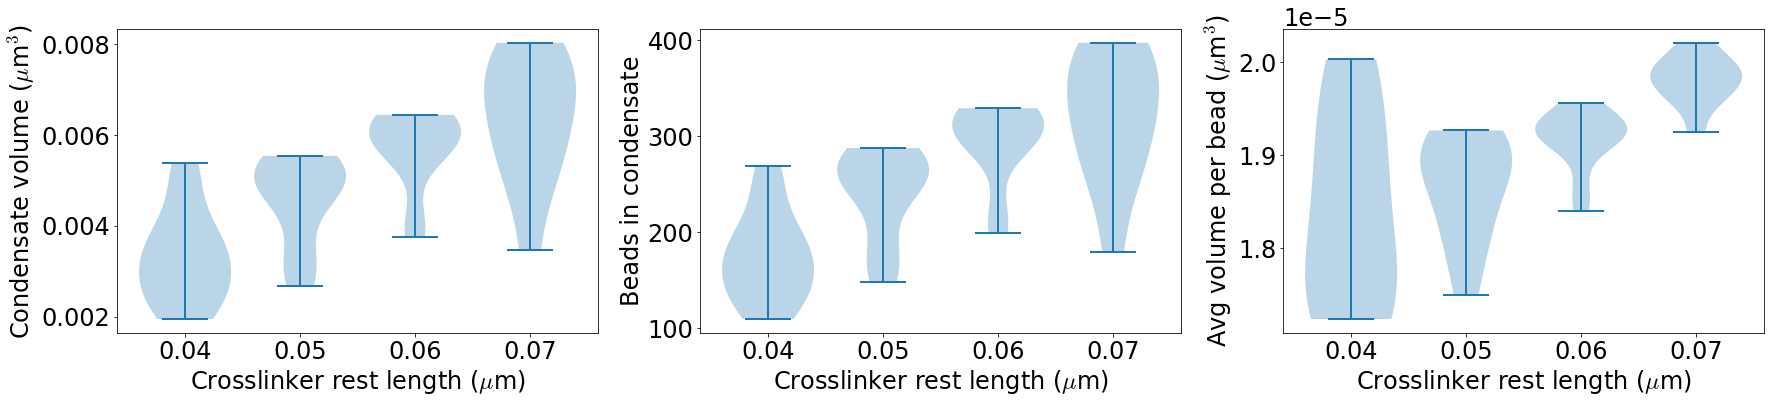

In [16]:
fig, axarr = plt.subplots(1,3, figsize=(25, 6))
_ = axarr[0].violinplot(volume_seed_avg_arr, positions=param_list, widths=.8*(param_list[1]-param_list[0]))
_ = axarr[1].violinplot(num_bead_seed_avg_arr, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
bvsaa = [ np.array(a)[~np.isnan(a)] for a in bead_vol_seed_avg_arr]

_ = axarr[2].violinplot(bvsaa, positions=param_list,widths=.8*(param_list[1]-param_list[0]))
for ax in axarr:
    _ = ax.set_xlabel('Crosslinker rest length ($\mu$m)')
_ = axarr[0].set_ylabel('Condensate volume ($\mu$m$^3$)')
_ = axarr[1].set_ylabel('Beads in condensate')
_ = axarr[2].set_ylabel('Avg volume per bead ($\mu$m$^3$)')

fig.tight_layout()

(199,)
number of estimated clusters : 45
number of thresholded clusters : 37
number of estimated clusters : 39
number of thresholded clusters : 34
number of estimated clusters : 37
number of thresholded clusters : 34
number of estimated clusters : 35
number of thresholded clusters : 34
number of estimated clusters : 37
number of thresholded clusters : 35


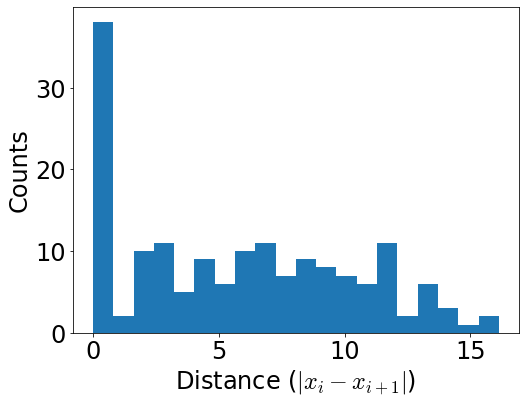

In [ ]:
data_path = (ceph_path /"22-07-15_aLc1_line16000_100umconf")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

ss_ind = -200
end_ind = -1

with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']
    print(time_arr.shape)

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    sep_arr = np.array([])
    N = 5
    for i in range(0,N):
        diff = int(time_arr.size / N)
        clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
            com_arr[:, :, diff*i])
        cluster_centers = np.array(cluster_centers)
        sep_mat = cluster_centers[:, np.newaxis, 0] - cluster_centers[np.newaxis, :, 0] 
        sep_arr = np.concatenate((sep_arr, np.abs(np.diagonal(sep_mat,i))))
    _ = axarr.hist(sep_arr, bins=20)
    _ = axarr.set_ylabel("Counts")
    _ = axarr.set_xlabel("Distance ($|x_i - x_{i+1}|$)") 


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


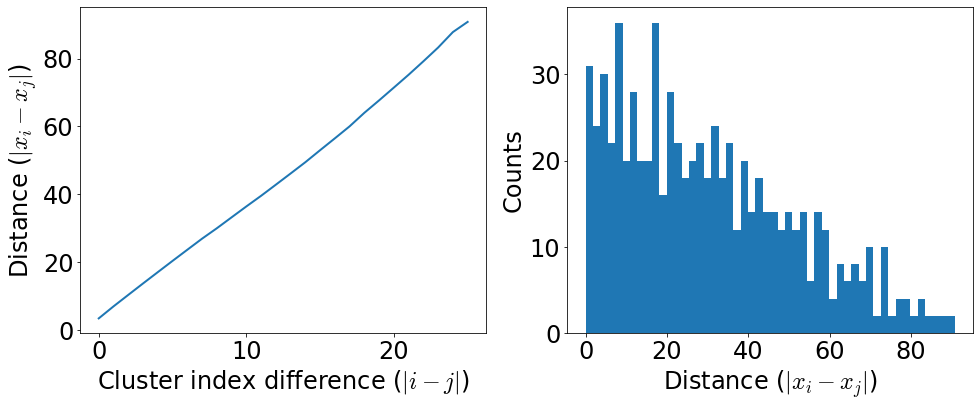

In [ ]:
data_path = (ws_path /"22-07-12_aLc1_line16000_sticky_100um")
ss_ind = 0
end_ind = -1
start_bead = 0
end_bead = None

fig, axarr = plt.subplots(4, 1, figsize=(18, 12), sharex=True, sharey=True)
with h5py.File(next(data_path.glob('analysis/*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    # analysis_grp = h5_data['analysis']

    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                           :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

clust, cluster_centers, cluster_label_inds = cca.identify_spatial_clusters(
com_arr[:, :, -1])

clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

for i in range(1,sep_mat.shape[0]):
        diag = np.diagonal(sep_mat, i)
        avg_dist_arr += [diag.mean()]
        avg_dist_sem_arr += [stats.sem(diag)]
        
_ = axarr[0].plot(np.abs(avg_dist_arr))
_ = axarr[0].set_ylabel("Distance ($|x_i - x_j|$)")
_ = axarr[0].set_xlabel("Cluster index difference ($|i-j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")

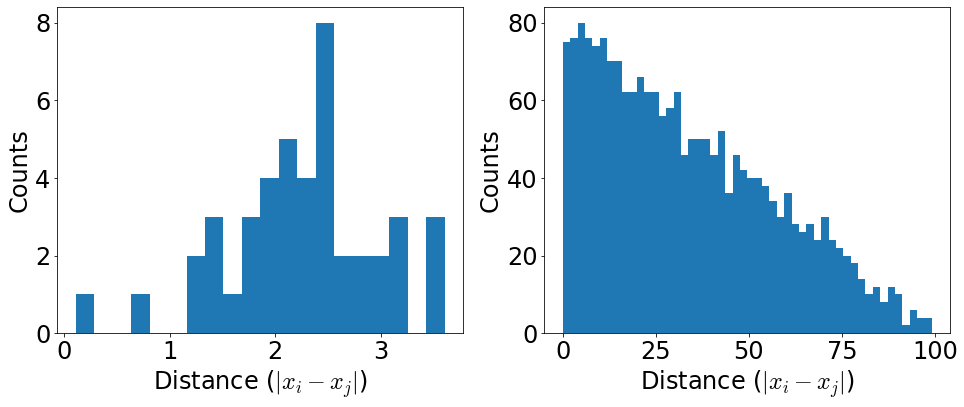

In [ ]:
clust_cen_arr = np.array(sorted(cluster_centers, key = lambda x: x[0]))

sep_mat = clust_cen_arr[:, np.newaxis, 0] - clust_cen_arr[np.newaxis, :, 0] 
avg_dist_arr = [] 
avg_dist_sem_arr = []
fig, axarr = plt.subplots(1,2, figsize=(16, 6))

diag = np.abs(np.diagonal(sep_mat, 1))
        
_ = axarr[0].hist(diag, bins=20)
_ = axarr[0].set_ylabel("Counts")
_ = axarr[0].set_xlabel("Distance ($|x_i - x_j|$)")
_ = axarr[1].hist(np.abs(sep_mat.flatten()), bins=50)
_ = axarr[1].set_ylabel("Counts")
_ = axarr[1].set_xlabel("Distance ($|x_i - x_j|$)")